In [1]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D,concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [3]:
Image_RGB = np.empty((len(Image),64,64,5))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][4],Image[i][3],Image[i][2],Image[i][1],Image[i][0]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])
show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.std((Image_RGB))

815


In [4]:
np.min(Image_RGB)

-12.046517871261704

In [5]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (14142, 64, 64, 5)
train_label.shape: (14142, 3)


In [28]:
batch_size =100
latent_dim = 3
nb_epoch = 50
epsilon_std = 0.5
intermediate_dim =512
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [29]:
vae.fit(train_data[:14000], train_data[:14000],
        shuffle=True,
        epochs=15,
        batch_size=batch_size,
        validation_data=(train_data[14000:14100],train_data[14000:14100]),callbacks=[EarlyStopping])

Train on 14000 samples, validate on 100 samples
Epoch 1/15
14000/14000 [==============================] - 23s - loss: -22553.4557 - val_loss: -23606.1504
Epoch 2/15
14000/14000 [==============================] - 22s - loss: -23203.8951 - val_loss: -23997.5430
Epoch 3/15
14000/14000 [==============================] - 22s - loss: -23509.6698 - val_loss: -24030.5469
Epoch 4/15
14000/14000 [==============================] - 21s - loss: -23607.9742 - val_loss: -24238.4277
Epoch 5/15
14000/14000 [==============================] - 21s - loss: -23674.0019 - val_loss: -24250.0039
Epoch 6/15
14000/14000 [==============================] - 21s - loss: -23701.7556 - val_loss: -24230.9121
Epoch 7/15
14000/14000 [==============================] - 22s - loss: -23705.8361 - val_loss: -24200.7188
Epoch 8/15
14000/14000 [==============================] - 21s - loss: -23712.8809 - val_loss: -24097.2773
Epoch 9/15
14000/14000 [==============================] - 21s - loss: -23731.2415 - val_loss: -24189.662

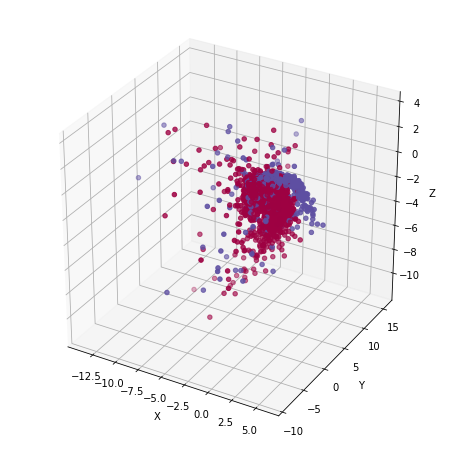

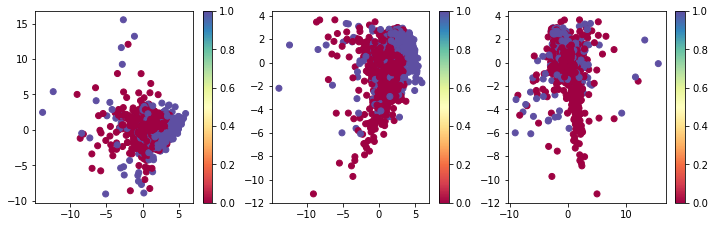

In [30]:
from mpl_toolkits.mplot3d import Axes3D
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =train_label[i,0]
    
vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8500:14000], batch_size=batch_size)  
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 0] ,x_vis[:, 1], x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
#plt.gray()
plt.show()



In [31]:
vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[8500:14000], batch_size=batch_size)

In [32]:
n_points = np.shape(x_vis)[0]
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data, batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)

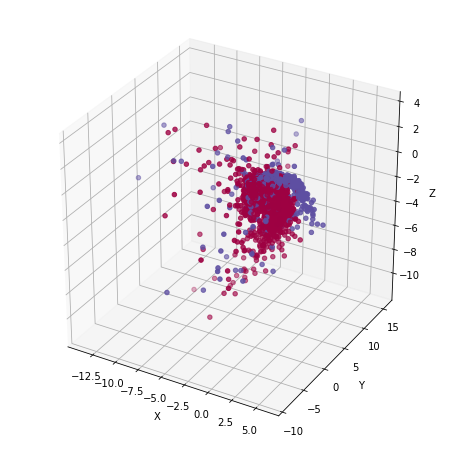

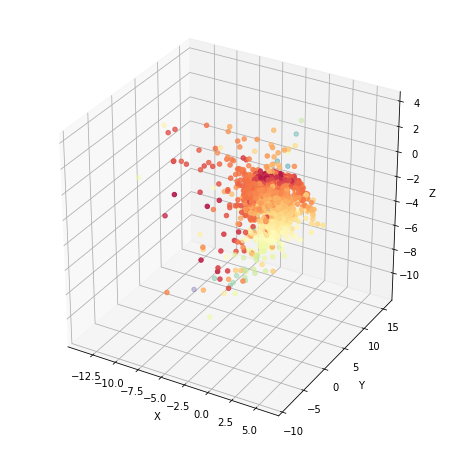

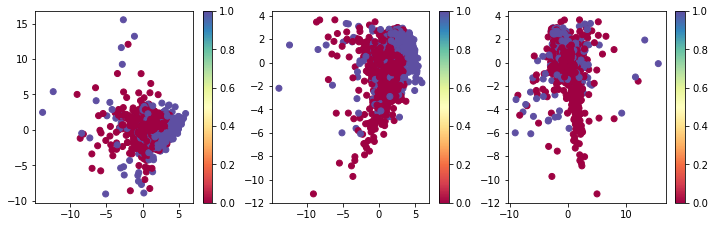

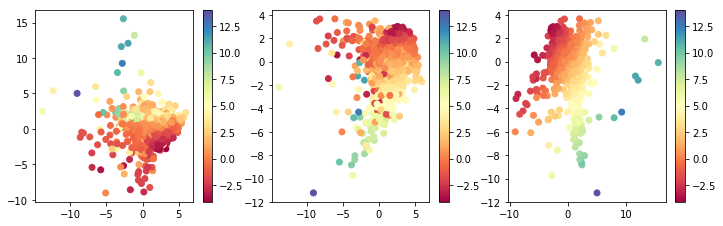

In [33]:
from mpl_toolkits.mplot3d import Axes3D
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =train_label[i,0]
if USE == 'autoencoder':
    vis = Model(input_img, encoded)
if USE == 'vae':
    vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8500:14000], batch_size=batch_size)  
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 0] ,x_vis[:, 1], x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 0] ,x_vis[:, 1], x_vis[:, 2],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
#plt.gray()
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
#plt.gray()
plt.show()

In [27]:
Y_pred =-Y_pred

In [40]:
count_ = 0
for i in range(len(x_vis)):
    if Y_pred[8500:14000][i]> -0.2685:
        count_+=1
print("predict abs with threshold above:\n",count_/len(x_vis))
print(" %.4g" % float(np.sum(Class[Class==1])/14142*100),"%")

predict abs with threshold above:
 0.6785454545454546
 67.85 %


In [41]:
count_gala = 0
for i in range(len(hid_pred)):
    if (Y_pred[i]> -0.2685):
        if Class[i]==1:
            count_gala+=1
print(count_gala/np.sum(Class[Class==1]))
print(np.sum(Class[Class==1])-count_gala)

0.906315131305
899


In [42]:
count_star = 0
for i in range(len(hid_pred)):
    if (Y_pred[i] < -0.2685):
        if Class[i]==0:
            count_star+=1
print(count_star/(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2))
print((len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)

0.791747978812
747.0


In [43]:
print("total accuracy is:",1-((np.sum(Class[Class==1])-count_gala)+(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)/len(Y_pred))

total accuracy is: 0.883609107623


In [44]:
n_points = np.shape(x_vis)[0]
n_neighbors = 10
n_components = 1
X = np.asarray(hid_pred,dtype='float64')
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y_pred = se.fit_transform(X)

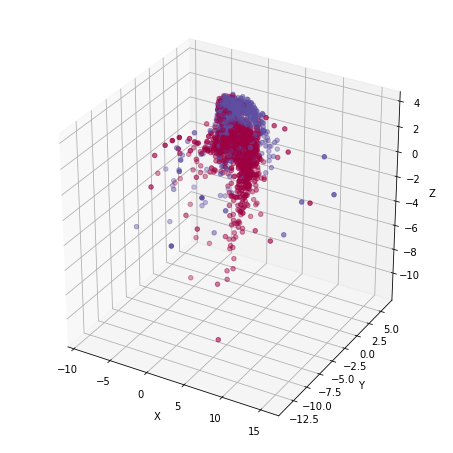

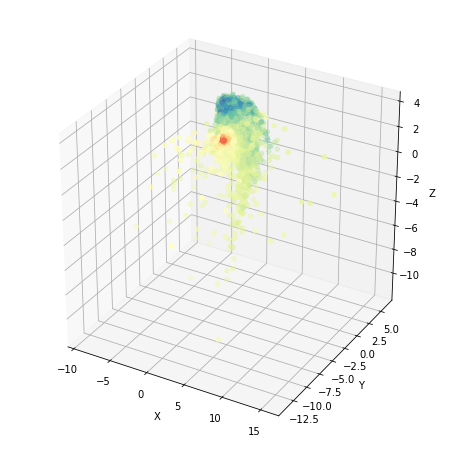

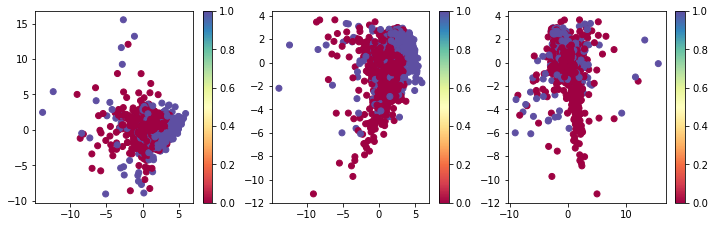

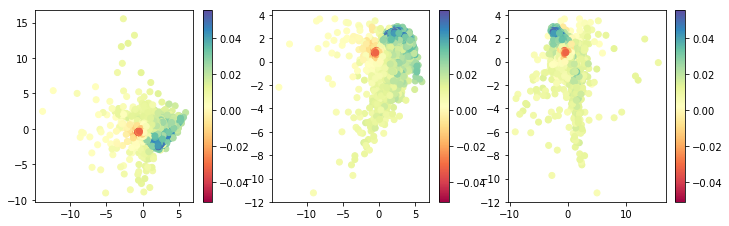

In [45]:
from mpl_toolkits.mplot3d import Axes3D
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =train_label[i,0]
if USE == 'autoencoder':
    vis = Model(input_img, encoded)
if USE == 'vae':
    vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8500:14000], batch_size=batch_size)  
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 1] ,x_vis[:, 0], x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 1] ,x_vis[:, 0], x_vis[:, 2],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
#plt.gray()
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
#plt.gray()
plt.show()

In [46]:
Y_pred =-Y_pred

In [55]:
count_ = 0
for i in range(len(x_vis)):
    if Y_pred[8500:14000][i]> -0.01641:
        count_+=1
print("predict abs with threshold above:\n",count_/len(x_vis))
print(" %.4g" % float(np.sum(Class[Class==1])/14142*100),"%")

predict abs with threshold above:
 0.6785454545454546
 67.85 %


In [56]:
count_gala = 0
for i in range(len(hid_pred)):
    if (Y_pred[i]>-0.01641):
        if Class[i]==1:
            count_gala+=1
print(count_gala/np.sum(Class[Class==1]))
print(np.sum(Class[Class==1])-count_gala)

0.79314297624
1985


In [57]:
count_star = 0
for i in range(len(hid_pred)):
    if (Y_pred[i] < -0.01641):
        if Class[i]==0:
            count_star+=1
print(count_star/(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2))
print((len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)

0.598271536103
1441.0


In [58]:
print("total accuracy is:",1-((np.sum(Class[Class==1])-count_gala)+(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)/len(Y_pred))

total accuracy is: 0.757742893509


In [59]:
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y_pred = tsne.fit_transform(X)

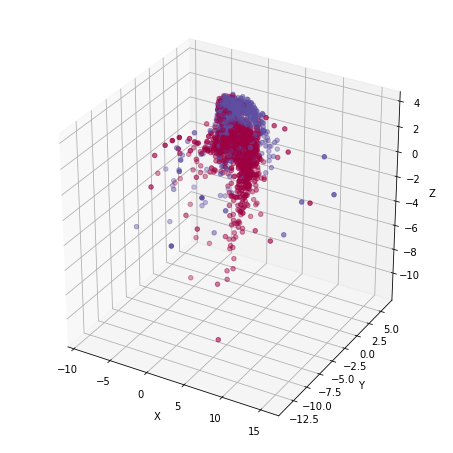

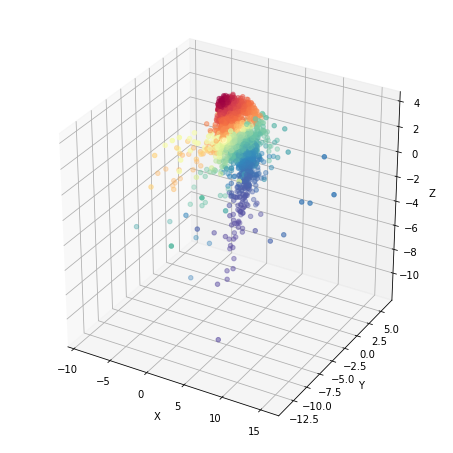

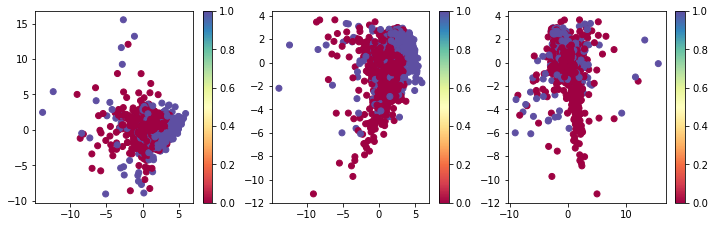

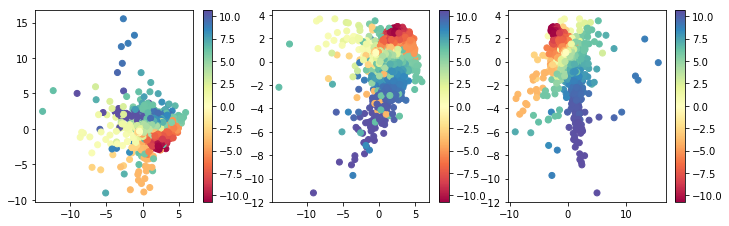

In [60]:
from mpl_toolkits.mplot3d import Axes3D
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =train_label[i,0]
if USE == 'autoencoder':
    vis = Model(input_img, encoded)
if USE == 'vae':
    vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8500:14000], batch_size=batch_size)  
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 1] ,x_vis[:, 0], x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 1] ,x_vis[:, 0], x_vis[:, 2],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=label_value[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
#plt.gray()
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=Y_pred[8500:14000],cmap=plt.cm.Spectral)
plt.colorbar()
#plt.gray()
plt.show()

In [ ]:
Y_pred =-Y_pred

In [73]:
count_ = 0
for i in range(len(x_vis)):
    if Y_pred[8500:14000][i]> -2.91:
        count_+=1
print("predict abs with threshold above:\n",count_/len(x_vis))
print(" %.4g" % float(np.sum(Class[Class==1])/14142*100),"%")

predict abs with threshold above:
 0.6783636363636364
 67.85 %


In [74]:
count_gala = 0
for i in range(len(hid_pred)):
    if (Y_pred[i]>-2.91):
        if Class[i]==1:
            count_gala+=1
print(count_gala/np.sum(Class[Class==1]))
print(np.sum(Class[Class==1])-count_gala)

0.905794080867
904


In [75]:
count_star = 0
for i in range(len(hid_pred)):
    if (Y_pred[i] < -2.91):
        if Class[i]==0:
            count_star+=1
print(count_star/(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2))
print((len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)

0.800390298299
716.0


In [76]:
print("total accuracy is:",1-((np.sum(Class[Class==1])-count_gala)+(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)/len(Y_pred))

total accuracy is: 0.885447602885
